<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Загрузим все нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from math import sqrt

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Проверим пропуски
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
# Проверим дубликаты
data.duplicated().sum()

26415

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic

In [6]:
data.index.is_monotonic

True

In [7]:
# Ресемплирование по одному часу
data = data.resample('1H').sum()

**Вывод:**

1. Данные были успешно загружены и имеют временной индекс, что важно для временных рядов.

2. В данных нет пропущенных значений.

3. Обнаружено большое количество дубликатов, это можно объяснить заказами такси в одно и то же время. 

4. Индекс времени является монотонно возрастающим.

5. После ресемплирования данных по одному часу, они готовы для дальнейшего анализа или построения модели прогнозирования количества заказов такси.

## Анализ

In [8]:
# Декомпозиция временного ряда
decomposed = seasonal_decompose(data)

In [9]:
# Получение тренда, сезонной и остаточной компонент
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

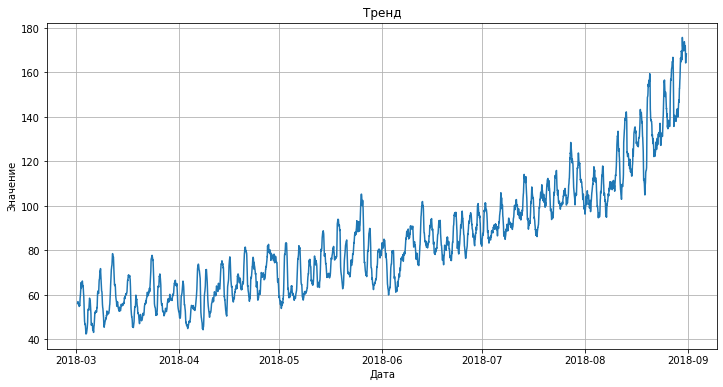

In [10]:
# График тренда
plt.figure(figsize=(12, 6))
plt.plot(trend)
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True) 
plt.show()

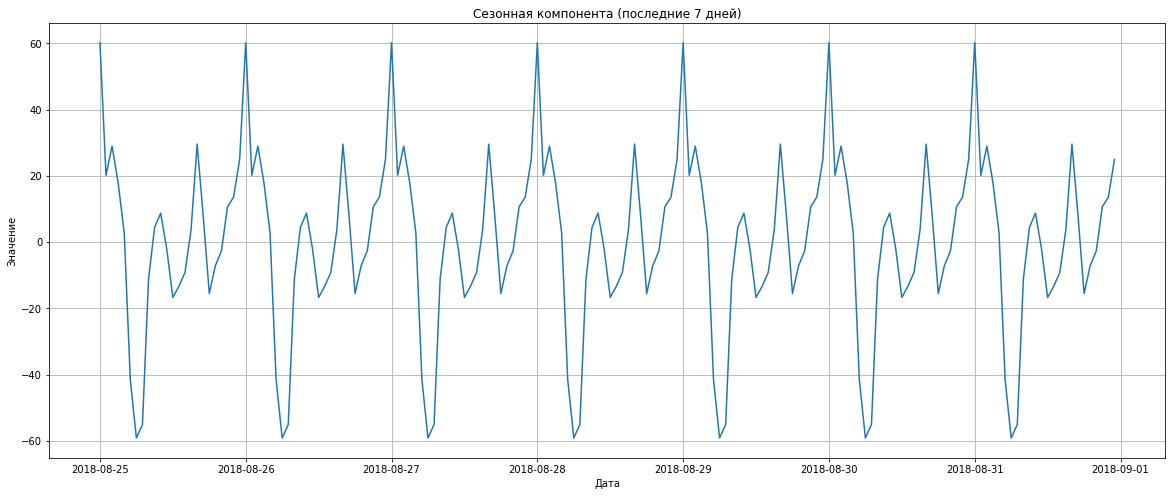

In [11]:
# График сезонной компоненты за последние 7 дней
plt.figure(figsize=(20, 8))
plt.plot(seasonal.tail(24*7))
plt.title('Сезонная компонента (последние 7 дней)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True) 
plt.show()

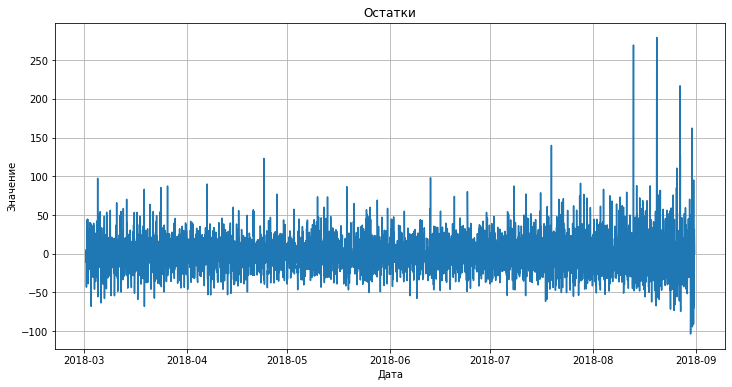

In [12]:
# График остатков
plt.figure(figsize=(12, 6))
plt.plot(residual)
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True) 
plt.show()

**Вывод:**
1. На графике тренда наблюдается ежемесячный восходящий тренд.
2. Сезонную компоненту я решил построить за последние 7 дней, чтобы график был более читаемым. Видно, что ночью заказы падают, днём растут, к вечеру достигается максимальное значение.
3. Шумы со временем увеличиваются.

## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице новые признаки:час и день недели, по аналогии с тренировочным заданием перед проектом.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [14]:
make_features(data, 24, 48)

In [15]:
# Удалим пропуски
data = data.dropna()

In [28]:
# Делим выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# Выделяем признаки и целевой признак
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# Размер обучающей и тестовой выборок
train_size = len(train)
test_size = len(test)

# Процентное соотношение
train_percentage = (train_size / len(data)) * 100
test_percentage = (test_size / len(data)) * 100

print(f"Размер обучающей выборки: {train_size}, {train_percentage:.2f}% от общего размера данных")
print(f"Размер тестовой выборки: {test_size}, {test_percentage:.2f}% от общего размера данных")

Размер обучающей выборки: 3931, 90.00% от общего размера данных
Размер тестовой выборки: 437, 10.00% от общего размера данных


Создадим функцию для расчёта RMSE, а также scorer - это функция из библиотеки scikit-learn (sklearn), которая позволяет создавать пользовательские оценщики (scorers). Оценщики используются для измерения производительности моделей, и они могут быть стандартными метриками, такими как среднеквадратичная ошибка (MSE), средняя абсолютная ошибка (MAE), или пользовательские метрики, такие как sMAPE (симметричное среднее абсолютное процентное отклонение).

In [17]:
def RMSE(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

# Создание метрики RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [18]:
# Создаем экземпляры TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
# Создаем экземпляры моделей
linear_reg_model = LinearRegression()
random_forest_model = RandomForestRegressor()
lightgbm_model = lgb.LGBMRegressor()

In [20]:
# Задаем параметры для Линейной регрессии
linear_reg_params = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Задаем параметры для Рандомного леса
random_forest_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Задаем параметры для LightGBM
lightgbm_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [21]:
# Создаем экземпляры GridSearchCV для каждой модели с TimeSeriesSplit
linear_reg_grid = GridSearchCV(linear_reg_model, linear_reg_params, cv=tscv, scoring=RMSE_score)
random_forest_grid = GridSearchCV(random_forest_model, random_forest_params, cv=tscv, scoring=RMSE_score)
lightgbm_grid = GridSearchCV(lightgbm_model, lightgbm_params, cv=tscv, scoring=RMSE_score)

In [22]:
# Обучение моделей с подбором гиперпараметров
linear_reg_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [23]:
random_forest_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [24]:
lightgbm_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [25]:
# Вывод лучших параметров для каждой модели
print("Linear Regression лучшие параметры:", linear_reg_grid.best_params_)
print("Random Forest лучшие параметры:", random_forest_grid.best_params_)
print("LightGBM лучшие параметры:", lightgbm_grid.best_params_)

# Вывод RMSE
print("RMSE для Линейной регрессии на тренировочной выборке:", -linear_reg_grid.best_score_)
print("RMSE для Случайного леса на тренировочной выборке:", -random_forest_grid.best_score_)
print("RMSE для LightGBM на тренировочной выборке:", -lightgbm_grid.best_score_)

Linear Regression лучшие параметры: {'fit_intercept': False, 'normalize': True}
Random Forest лучшие параметры: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
LightGBM лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
RMSE для Линейной регрессии на тренировочной выборке: 27.115822613861305
RMSE для Случайного леса на тренировочной выборке: 25.15790157192233
RMSE для LightGBM на тренировочной выборке: 24.840052851256868


## Тестирование

In [26]:
# Предсказания модели Linear Regression на тестовой выборке
linear_reg_test_predictions = linear_reg_grid.predict(features_test)
linear_reg_test_rmse = RMSE(target_test, linear_reg_test_predictions)

# Предсказания модели Random Forest на тестовой выборке
random_forest_test_predictions = random_forest_grid.predict(features_test)
random_forest_test_rmse = RMSE(target_test, random_forest_test_predictions)

# Предсказания модели LightGBM на тестовой выборке
lightgbm_test_predictions = lightgbm_grid.predict(features_test)
lightgbm_test_rmse = RMSE(target_test, lightgbm_test_predictions)

# Вывод RMSE на тестовой выборке для каждой модели
print("RMSE для Линейной регрессии на тестовой выборке:", linear_reg_test_rmse)
print("RMSE для Случайного леса на тестовой выборке:", random_forest_test_rmse)
print("RMSE для LightGBM на тестовой выборке:", lightgbm_test_rmse)


RMSE для Линейной регрессии на тестовой выборке: 45.25470929321797
RMSE для Случайного леса на тестовой выборке: 43.14105787672591
RMSE для LightGBM на тестовой выборке: 41.620523658816346


Визуализируем предсказанные и реальные значения.

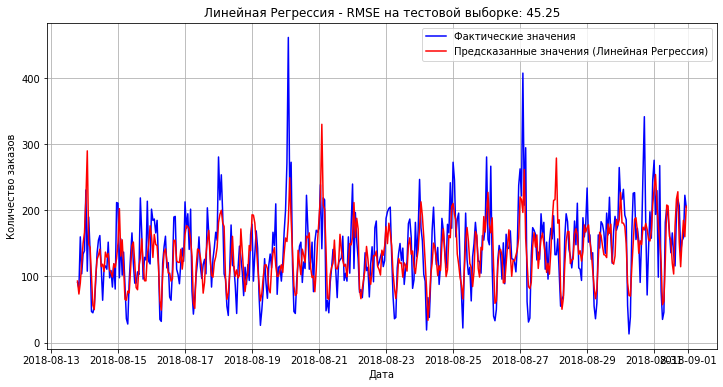

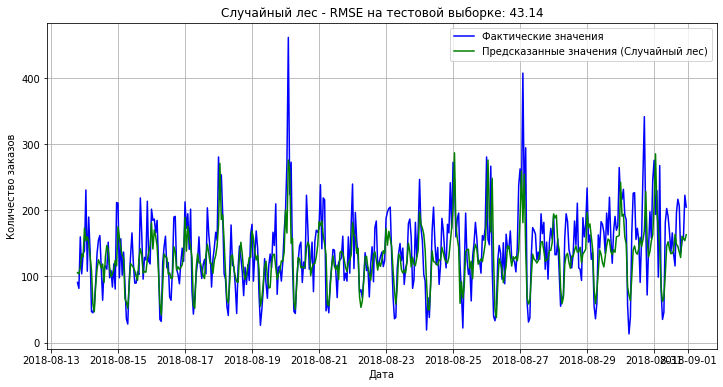

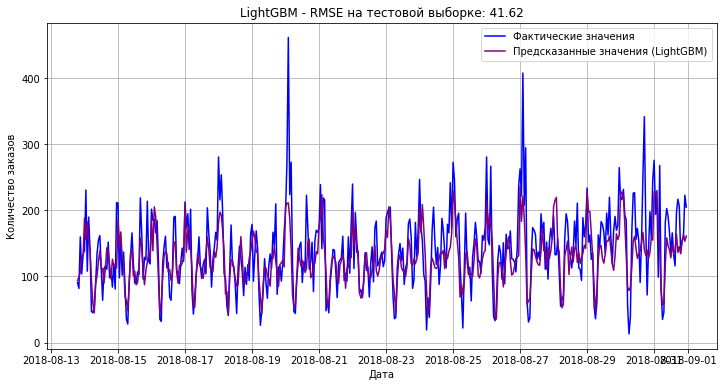

In [27]:
# График для Линейной Регрессии на тестовой выборке
plt.figure(figsize=(12, 6))
plt.plot(features_test.index, target_test, label="Фактические значения", color="blue")
plt.plot(features_test.index, linear_reg_test_predictions, label="Предсказанные значения (Линейная Регрессия)", color="red")
plt.title(f"Линейная Регрессия - RMSE на тестовой выборке: {linear_reg_test_rmse:.2f}")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend()
plt.grid(True)
plt.show()

# График для Случайного леса на тестовой выборке
plt.figure(figsize=(12, 6))
plt.plot(features_test.index, target_test, label="Фактические значения", color="blue")
plt.plot(features_test.index, random_forest_test_predictions, label="Предсказанные значения (Случайный лес)", color="green")
plt.title(f"Случайный лес - RMSE на тестовой выборке: {random_forest_test_rmse:.2f}")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend()
plt.grid(True)
plt.show()

# График для LightGBM на тестовой выборке
plt.figure(figsize=(12, 6))
plt.plot(features_test.index, target_test, label="Фактические значения", color="blue")
plt.plot(features_test.index, lightgbm_test_predictions, label="Предсказанные значения (LightGBM)", color="purple")
plt.title(f"LightGBM - RMSE на тестовой выборке: {lightgbm_test_rmse:.2f}")
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.legend()
plt.grid(True)
plt.show()

## Общий вывод

Конечно! Вот общий вывод по вашему проекту:

---

**Анализ и прогнозирование количества заказов такси**

В ходе проекта было выполнено следующее:

1. **Подготовка данных:**
   - Проведено ресемплирование данных по одному часу.
   - Разделение данных на обучающую и тестовую выборки в соотношении 90/10.

2. **Обучение моделей:**
   - Были выбраны три модели: Линейная регрессия, Случайный лес, LightGBM.
   - Произведена настройка гиперпараметров моделей с использованием TimeSeriesSplit.

3. **Оценка моделей:**
   - На обучающей выборке были получены следующие значения RMSE:
     - Линейная регрессия: 27.12
     - Случайный лес: 25.15
     - LightGBM: 24.84
   - На тестовой выборке были получены следующие значения RMSE:
     - Линейная регрессия: 45.25
     - Случайный лес: 43.14
     - LightGBM: 41.62

4. **Визуализация результатов:**
   - Построены графики с фактическими и предсказанными значениями для каждой модели на тестовой выборке.
   - RMSE на тестовой выборке добавлен в заголовки графиков.

**Итоговый вывод:**

Исходя из результатов оценки моделей, LightGBM показал наилучшую эффективность, имея наименьшее значение RMSE как на обучающей, так и на тестовой выборке.